### Deep Portfolio Optimization

Consider stock $S_t$ and bond $B_t$ and initial Wealth $V_0$. The wealth process is controlled by our trading strategy, equivalently speaking the proportion $\alpha_t$ of wealth $V_t$ we invest in stock, and the rest in bond. 
$$
\frac{dV_t}{V_t} = \alpha_t\frac{dS_t}{S_t} + (1-\alpha_t)\frac{dB_t}{B_t}.
$$
We aim at maximizing our expected utility i.e. 
$$
\min_{\alpha} \mathbb{E}[u(V_T)].
$$
For example, when $B_t$ is exponential and $S_t$ is exponential Brownian Motion
$$
\frac{dB_t}{B_t} = rdt, \quad  \frac{dS_t}{S_t} = \mu dt + \sigma dW_t,
$$
and $u$ be the log utility: $u(x) = \log(x)$. The the optimal $\alpha_t^{*} = \frac{\mu - r}{\sigma^2}$


In [1]:
%load_ext autoreload
%autoreload 2
import torch
from neuralhedge.data.stochastic import BlackScholesDataset, simulate_time
from neuralhedge.data.base import ManagerDataset
import matplotlib.pyplot as plt
import numpy as np 

from neuralhedge.nn.blackschole import BlackScholesAlpha
from neuralhedge.nn.datamanager import Manager

In [2]:
n_sample = 50000
n_timestep = 10
dt = 1/10

mu = 0.2
sigma = 0.2
r = 0.1

ds_bs = BlackScholesDataset(n_sample = n_sample,
                          n_timestep = n_timestep,
                          dt = dt,
                          mu = mu,
                          sigma = sigma)
stock = ds_bs.paths*100
time = simulate_time(n_sample, dt, n_timestep, reverse = False)
bond = torch.exp(r*time)*100
paths = torch.cat([ds_bs.paths, bond], dim = -1)

The utility is 0.226


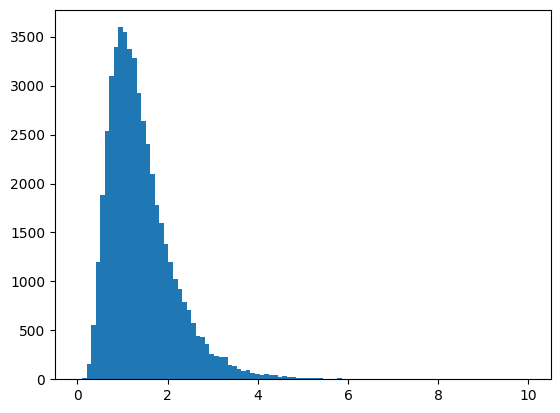

In [3]:
from neuralhedge.nn.loss import log_utility
model = BlackScholesAlpha(mu, sigma, r)
manager = Manager(model)
terminal_wealth = manager([paths,paths])[-1]
utility = log_utility(terminal_wealth).mean().numpy()
print('The utility is {:.3f}'.format(utility)) 
plt.hist(terminal_wealth, bins = list(np.linspace(0,10,100)))
plt.show()

Loss=-0.22276222705841064: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


The utility is 0.226


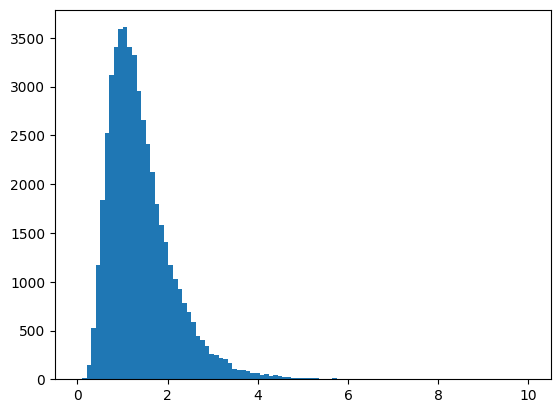

In [4]:
from neuralhedge.nn.mlp import SingleWeight
model = SingleWeight()
manager = Manager(model)
manager_ds = ManagerDataset([paths,paths])
manager.fit(manager_ds,EPOCHS = 20)
with torch.no_grad():
    terminal_wealth = manager([paths,paths])[-1]   
utility = log_utility(terminal_wealth).mean().numpy()
print('The utility is {:.3f}'.format(utility)) 
plt.hist(terminal_wealth, bins = list(np.linspace(0,10,100)))
plt.show()

In [5]:
print('The optimal ratio: {:.2f}'.format((mu-r)/sigma**2))
print('The learned ratio: {:.2f}'.format(model.weight.item()))

The optimal ratio: 2.50
The learned ratio: 2.47
